In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
import tensorflow as tf 
from tensorflow import keras
import csv
import os
from keras import backend as K
import math
from scipy.stats import norm
import os
import re

In [2]:
#Here I am basically taking one catalog that I rotated 3000 times and getting all the data 
#to put into the machine learning thing 

#cutoff = 11100
#this is the length I'm cutting off the data just arbitrarily when I'm using multiple catalogs
#but here since i'm only using one it doesn't matter 

master_rshift = []
master_dist_mod = [] #errors added on 
master_glat = [] 
master_glon = [] 
#lengths = []
#I use this to determine the shortest length of data when using varied catalogs 

for x in os.listdir("C:/Users/19133/Documents/Research/Feldman/ML/Rotated_same/"):
    data = np.load("C:/Users/19133/Documents/Research/Feldman/ML/Rotated_same/"+x)
    master_rshift.append(data['redshift'])
    master_dist_mod.append(data['distm'] + data['distmerr'])
    master_glat.append(data['glat'])
    master_glon.append(data['glon'])
    #lengths.append(len(data['redshift']))

data = np.load("C:/Users/19133/Documents/Research/Feldman/ML/Rotated_Catalog_Bulkflows2.npy.npz")
master_bulkflows = data['bulkflow']

#I scale the data to be between 0 and 1 here, where I am scaling it by the 
#largest value of all the data, as opposed to scaling each by 
#the maximum of that array respectively 
#not sure if this is the best approach? 

redshift = np.array(master_rshift)/np.max(np.concatenate(np.array(master_rshift))) 
distm = np.array(master_dist_mod)/np.max(np.concatenate(np.array(master_dist_mod)))
glat = np.array(master_glat)/np.max(np.concatenate(np.array(master_glat)))
glon = np.array(master_glon)/np.max(np.concatenate(np.array(master_glon)))

In [3]:
#Here I am preparing the data into it's training and testing sets 

X = np.stack([redshift,distm,glat,glon],axis=-1)
y = np.array(master_bulkflows)
train_percent = 0.75 
X_train,X_test = (X[:int(3000*train_percent)], X[int(3000*train_percent)::])
y_train,y_test = (y[:int(3000*train_percent)], y[int(3000*train_percent)::])

In [4]:
#okay this is where it gets messy 
#so I had to write the program in a bit different formalism for it to work but it seems to mean the same 
#the below is the input, which is the size of the amount of arrays in each catalog
#with the 4 being the size of each of those arrays (rshift, distmod, glat, glon)

inputs = tf.keras.Input(shape=(11638,4))

#here, it's like adding a first layer, where the (inputs) means you're putting the last thru this one 
x = tf.keras.layers.Conv1D(32, 2, activation='tanh')(inputs)

#here you're doing the same thing, putting the last (x) in this new layer (x2) 
#the input shape is from the shape that the previous (x) CONV layer outputs 
#I don't know quite what the shape *means*, but you have to basically have the 
#input shape of a layer be whatever shape the last one output 
x2 = tf.keras.layers.Conv1D(32, 2, input_shape=(11043,32), activation='tanh')(x)

#now to put in our last layer, the dense layer, we have to flatten it to get our 3D single arrays 
#Flatten is itself a type of layer 
x3 = tf.keras.layers.Flatten()(x2)
outputs = tf.keras.layers.Dense(3,activation='linear')(x3)

model1 = tf.keras.Model(inputs=inputs,outputs=outputs)
optimizer = tf.keras.optimizers.Adam(lr=0.00001)
model1.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
model1.fit(X_train,y_train,epochs=5)

Epoch 1/5
71/71 [==============================] - 11s 150ms/step - loss: 77532.0059 - accuracy: 0.3643
Epoch 2/5
71/71 [==============================] - 11s 151ms/step - loss: 77480.4396 - accuracy: 0.3555
Epoch 3/5
71/71 [==============================] - 11s 151ms/step - loss: 77541.7980 - accuracy: 0.3537
Epoch 4/5
71/71 [==============================] - 11s 151ms/step - loss: 77474.7180 - accuracy: 0.3534
Epoch 5/5
71/71 [==============================] - 11s 151ms/step - loss: 77429.5137 - accuracy: 0.3751


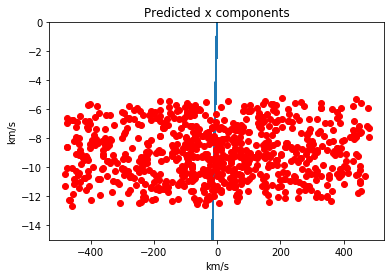

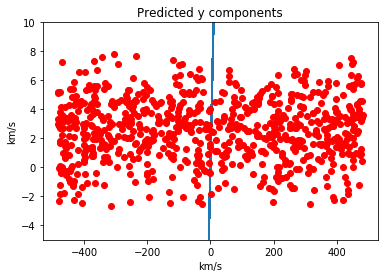

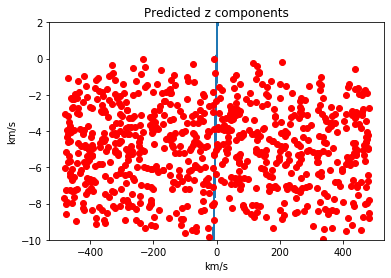

In [5]:
y_pred = model1.predict(X_test)
plt.plot(y_test[:,0],y_test[:,0])
plt.plot(y_test[:,0],y_pred[:,0],'ro')
plt.ylim(-15,0)
plt.title('Predicted x components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.show()

plt.plot(y_test[:,1],y_test[:,1])
plt.plot(y_test[:,1],y_pred[:,1],'ro')
plt.ylim(-5,10)
plt.title('Predicted y components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.show()

plt.plot(y_test[:,2],y_test[:,2])
plt.plot(y_test[:,2],y_pred[:,2],'ro')
plt.ylim(-10,2)
plt.title('Predicted z components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.show()


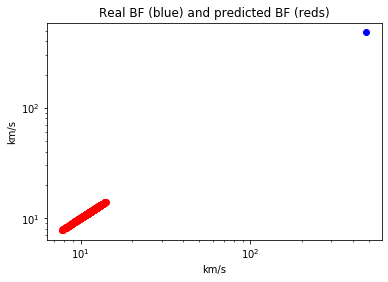

In [7]:
real_bf = np.sqrt(y_test[0][0]**2 + y_test[0][1]**2 + y_test[0][2]**2)
plt.plot(real_bf,real_bf,'bo')

for x in range(len(y_pred)): 
    pred_bf = np.sqrt(y_pred[x][0]**2 + y_pred[x][1]**2 + y_pred[x][2]**2)
    plt.plot(pred_bf,pred_bf,'ro')
    plt.loglog()
    plt.title('Real BF (blue) and predicted BF (reds)')
    plt.xlabel('km/s')
    plt.ylabel('km/s')